# Lab Five: Wide and Deep Network Architectures

# James Thomas, Xiaoxian Jing, Kuang Yan

 1. [Dataset Selection](#data)<br>
 2. [Preparation](#prep)<br>
  2.1 [Define Class Variables](#class_variables)<br>
  2.2 [Cross-Product-Features](#cross_product_features)<br>
  2.3 [Metric](#metric)<br>
  3.4 [Test-Train Split](#split)<br>
 3. [Modeling](#modeling)<br>
  3.1 [Classify Using Keras](#keras)<br>
  3.2 [Generalization Performance](#generalization)<br>
  3.3 [Compare to Multi-Layer Perceptron](#compare)<br>
 4. [Exceptional Work](#exceptional)<br>
  4.1 [Additional Analysis](#additional_analysis)<br>
  4.2 [Embedded Weights](#embedded_weights)<br>
 5. [Final Thoughts](#thoughts)<br>
  
[//]: # (put the html anchors above the titles for better scrolling)
[//]: # (note the <br>, and why do I need .. for 3rd level?, maybe I should just use pureish html)

<a id="data"></a>
## Dataset Selection
Select a dataset identically to the way you selected for lab one or lab three (table data or image data). You are not required to use the same dataset that you used in the past, but you are encouraged. You must identify a classification task from the dataset that contains __three or more classes__ to predict. That is, it cannot be a binary classification; it must be multi-class prediction. 

<a id="prep"></a>
## Preparation __(40 points total)__

<a id="class_variables"></a>
### Define Class Variables

> __[10 points]__ Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification (include a description of any newly formed variables you created).

In [1]:
# load the full dataset
import keras
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
from keras.layers import concatenate

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics as mt
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix

from keras import backend as K

import random
import warnings
warnings.filterwarnings('ignore')

/hpc/applications/anaconda/3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [77]:
plt.style.use('ggplot')
%matplotlib inline

full_df = pd.read_csv('data/diabetic_data.csv')

full_df = full_df.head(50000)

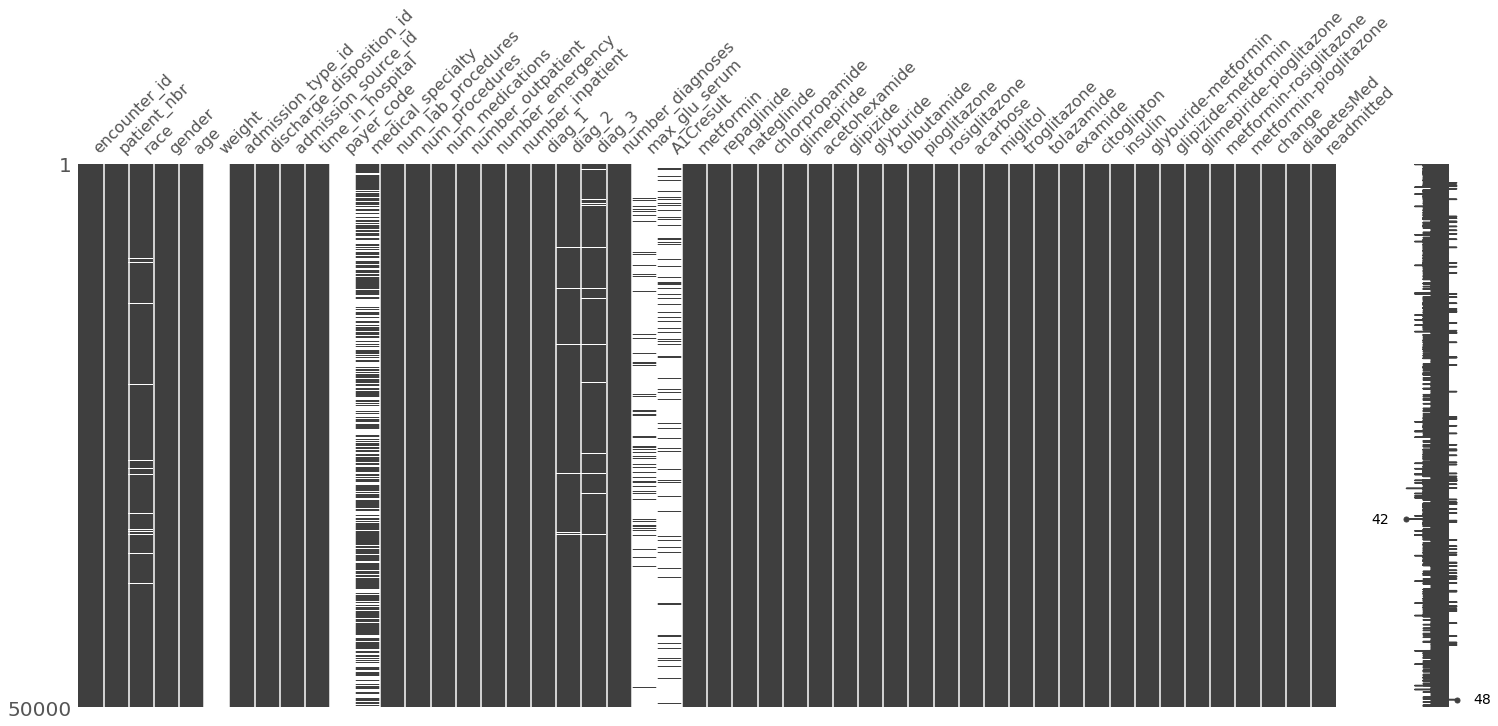

In [78]:
# now convert columns that should be numeric to numeric types,

import os
if os.getcwd().find('jamesthomas'):
    import sys
    sys.path.append('/users/jamesthomas/python_packages/')
    import missingno as mn
        
# first force the columns that should be numeric to numeric
numeric_cols = ['weight','payer_code']
full_df[numeric_cols]=full_df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# now replace the '?' in the string data
full_df.replace({'?':None,'None':None}, inplace = True)
mn.matrix(full_df)

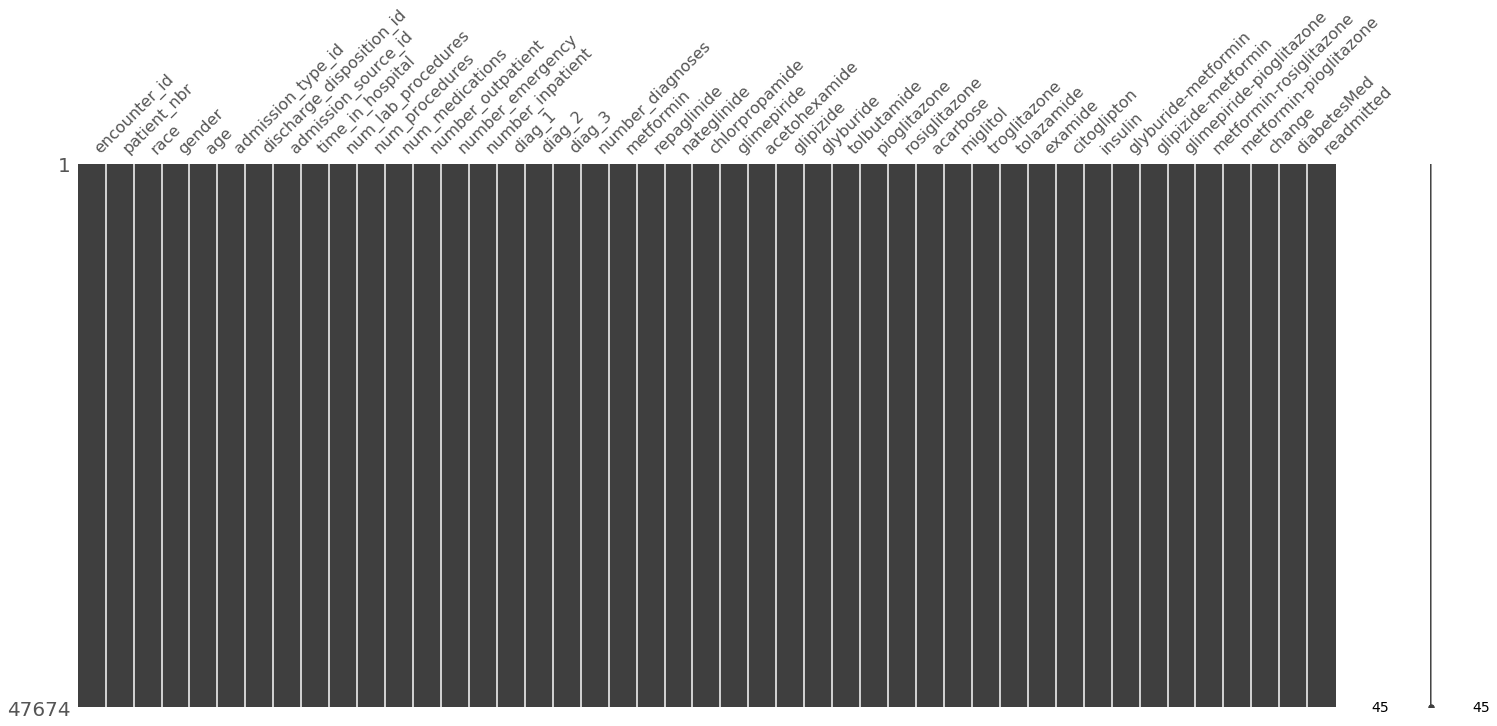

In [79]:
# then drop the columns missing too much data and then the rows with any missing data. 

cols = list(full_df)
datas = list(full_df.isnull().sum())
size = full_df.shape[0]
drop_cols = []
threshold = 0.08
for i in range(len(cols)):
    if datas[i]/size > threshold:
        drop_cols.append(cols[i])

full_df.drop(drop_cols, axis=1, inplace=True)
full_df.dropna(inplace=True)

mn.matrix(full_df)

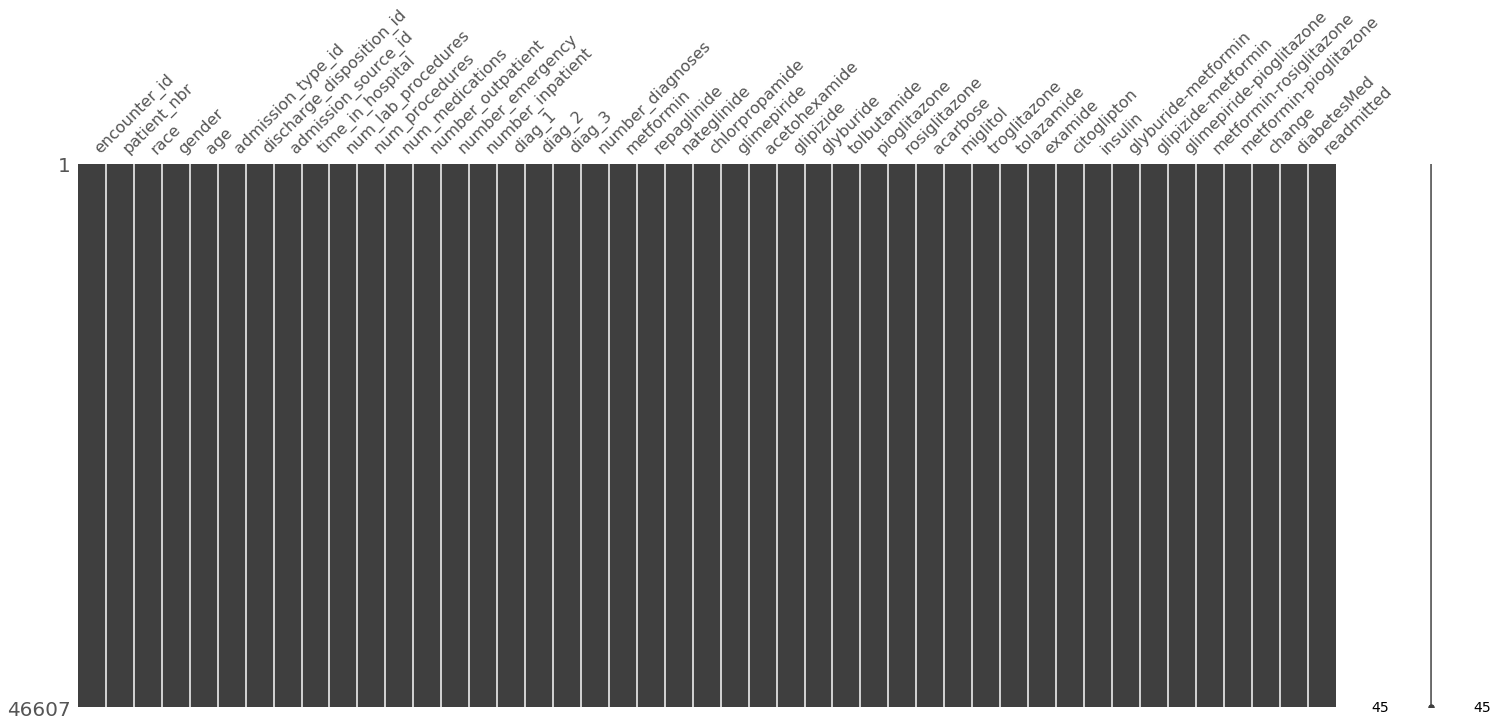

In [80]:
# now drop some rows based on discharge disposition
discharge_disp_ids = [11, 13, 14, 19, 20, 21]
full_df = full_df.loc[~full_df.discharge_disposition_id.isin(discharge_disp_ids)]
mn.matrix(full_df)

In [81]:
# some helper functions for data conversion
def one_hot_encode(df, column):
    '''If the column only contains a single value, there is no information so don't do anything,
    otherwise one hot encode the column
    '''
    col_names = []
    if len(df[col].unique()) != 1:
        # more than one value in category
        df[column] = pd.Categorical(df[column])
        dfDummies = pd.get_dummies(df[column], prefix = column+'_category', drop_first=True) # added drop_first
        col_names.append(list(dfDummies))
        df = pd.concat([df, dfDummies], axis=1)
    return df, col_names

def diag_categorize(val):
    '''More information about the categories can be found at http://www.icd9data.com/
    '''
    try:
        val = float(val)
        if val < 140:
            return('Infectious and Parasitic Disease')
        elif val < 240:
            return('Neoplasms')
        elif val < 280:
            return('Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders')
        elif val < 290:
            return('Diseases Of The Blood And Blood-Forming Organs')
        elif val < 320:
            return('Mental Disorders')
        elif val < 390:
            return('Diseases Of The Nervous System And Sense Organs')
        elif val < 460:
            return('Diseases Of The Circulatory System')
        elif val < 520:
            return('Diseases Of The Circulatory System')
        elif val < 580:
            return('Diseases Of The Digestive System')
        elif val < 630:
            return('Diseases Of The Genitourinary System')
        elif val < 680:
            return('Complications Of Pregnancy, Childbirth, And The Puerperium')
        elif val < 710:
            return('Diseases Of The Skin And Subcutaneous Tissue')
        elif val < 740:
            return('Diseases Of The Musculoskeletal System And Connective Tissue')
        elif val < 760:
            return('Congenital Anomalies')
        elif val < 780:
            return('Certain Conditions Originating In The Perinatal Period')
        elif val < 800:
            return('Symptoms, Signs, And Ill-Defined Conditions')
        else:
            return('Injury And Poisoning')
    except:
        if val[0]=='V':
            return('Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services')
        elif val[0]=='E':
            return('Supplementary Classification Of External Causes Of Injury And Poisoning')
        else:
            print(val)
            return(None)
        
def type_id_trans(val):
    return str(val)

In [82]:
# these are the columns that use the ICD9 data

explain_list = ['diag_1', 'diag_2', 'diag_3']
for diag in explain_list:
    full_df[diag+'_explain'] = full_df[diag].apply(diag_categorize)
type_id_list = ['admission_type_id','discharge_disposition_id','admission_source_id']
for diag in type_id_list:
    full_df[diag] = full_df[diag].apply(type_id_trans)

In [83]:
# Now we will convert the 'patient_nbr' column to a new column that shows counts how many times the patient visitied
# the hospital in the study
full_df['freq'] = full_df.groupby('patient_nbr')['patient_nbr'].transform('count')

In [84]:
#remove abnormal values
full_df['gender'] = full_df['gender'].replace({'Unknown/Invalid':None})

In [85]:
# these are the columns that are no longer relevant, either because we transformed the data or it is just an id
drop_not_relevant = ['encounter_id', 'patient_nbr']
full_df.drop(drop_not_relevant, axis=1, inplace=True)

In [86]:
full_df['age'] = full_df['age'].replace({'[0-10)':0,'[10-20)':1,'[20-30)':2,'[30-40)':3,'[40-50)':4,
                                         '[50-60)':5,'[60-70)':6,'[70-80)':7,'[80-90)':8,'[90-100)':9})

In [87]:
full_df.dropna(inplace=True) # to drop any None types that come up from the conversions

In [88]:
standard_scalar_list = ['age', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
                        'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'freq']

In [89]:
# these are the columns that need one hot encoded

one_hot_encode_list = ['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide',
                       'glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone',
                       'tolazamide','examide','citoglipton','glyburide-metformin','glipizide-metformin',
                       'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone',
                       'diag_1_explain','diag_2_explain','diag_3_explain','race','admission_type_id',
                       'discharge_disposition_id','admission_source_id','insulin']

labe_encod_list = ['gender','change','diabetesMed']

In [90]:
from copy import deepcopy
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(full_df, test_size=0.2, random_state=0, stratify=full_df['readmitted'])

#df_train = deepcopy(full_df)
#df_test = deepcopy(full_df)

In [91]:
categorical_headers = one_hot_encode_list+labe_encod_list
numeric_headers = standard_scalar_list

In [92]:
# scale the numeric, continuous variables
for col in numeric_headers:
    df_train[col] = df_train[col].astype(np.float)
    df_test[col] = df_test[col].astype(np.float)
    
    ss = StandardScaler()
    df_train[col] = ss.fit_transform(df_train[col].values.reshape(-1, 1))
    df_test[col] = ss.transform(df_test[col].values.reshape(-1, 1))

In [93]:
# define objects that can encode each variable as integer    
encoders = dict() 

#some labels have rare values, thus we use the encoder on the full_df first then apply to the train&test set

# train all encoders
for col in categorical_headers:
    full_df[col] = full_df[col].str.strip()
    df_train[col] = df_train[col].str.strip()
    df_test[col] = df_test[col].str.strip()
    
    # integer encoded variables
    encoders[col] = LabelEncoder() # save the encoder
    full_df[col+'_int'] = encoders[col].fit_transform(full_df[col])
    #df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
    df_train[col+'_int'] = encoders[col].transform(df_train[col])
    df_test[col+'_int'] = encoders[col].transform(df_test[col])

categorical_headers_ints = [x+'_int' for x in categorical_headers]

In [94]:
# we will forego one-hot encoding right now and instead just scale all inputs
#   this is just to get an example running in Keras (don't ever do this)
#feature_columns = categorical_headers_ints+numeric_headers
#X_train =  ss.fit_transform(df_train[feature_columns].values).astype(np.float32)
#X_test =  ss.transform(df_test[feature_columns].values).astype(np.float32)

#for multiclass classfication
y_train = df_train['readmitted'].replace({'NO':0,'<30':1,'>30':2}).values
y_test = df_test['readmitted'].replace({'NO':0,'<30':1,'>30':2}).values

#for multi-classification
nb_classes = 3

y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

<a id="cross_product_features"></a>
### Cross Product Features

> __[10 points]__ Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed). 

In [95]:
final_cross_columns = [['admission_type_id','admission_source_id','discharge_disposition_id'],
                 ['gender','race'],
                 ['repaglinide','nateglinide'],
                 ['diag_1_explain','diag_2_explain','diag_3_explain'],
                 ['glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone','pioglitazone','rosiglitazone'],
                 ['glyburide-metformin','glipizide-metformin']
                ]

So the reason I choose these groups is based on the type of the medicine they are.

Certain types of medicines when used together will provide vital information about the condition of the patients, thus I choose them to be crossed.

Also, the admission_type_id, admission_source_id, discharge_disposition_id when combined together may provide some ideas about the financial status of the patient, which can be related to their treatment of diabetes, which should be important.

People of different gender and race have different physical condition, hence we also need to remember these.

<a id="metric"></a>
### Metric

>__[10 points]__ Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a __detailed argument for why this (these) metric(s) are appropriate__ on your data. That is, why is the metric appropriate for the task (_e.g_., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

In an ideal world, we would want to use a metric that is widely used in the medical analysis field so that we could directly compare our model with others. However, we have not been able to find many publications about this. We did find one [paper](https://www.hindawi.com/journals/bmri/2014/781670/), but it appears to be using the dataset to answer a different question that we are. The authors are analyzing the impact of the hemoglobin a1c result and we dropped that featrue because it was missing too much data. The paper also makes extensive use of the [P-value](https://www.dummies.com/education/math/statistics/what-a-p-value-tells-you-about-statistical-data/) which is an acceptable method for hypothesis testing, but it does not apply a quantitative value that describes the "goodness" of our model. There are also [references](https://www.ischool.berkeley.edu/projects/2017/what-are-predictors-medication-change-and-hospital-readmission-diabetic-patients) using, precision, recall, area under the ROC curve, and accuracy. 

Since there does not appear to be a single, widely used, metric used. We will difine our own. To do this we will define a cost matrix which reflects the relative cost of false positives, false netatives, and correct predictions by our model. This cost matix will then be multiplied by the confusion matrix predicted by our model and the resulting elements will be summed to create the aggregate cost. Now we just have to define the relative cost of each mistake. A sample cost matrix could be:

<table>
<tr>
    <td colspan="2"></td>
    <td colspan="3">Actual Class</td>
</tr>
<tr>
    <td colspan="2"></td>
    <td>NO</td>
    <td>&gt;30</td>
    <td>&lt;30</td>
</tr>
<tr>
    <td rowspan="3">Predicted Class</td>
    <td>NO</td>
    <td>neither good nor bad</td>
    <td>really bad</td>
    <td>really bad</td>
</tr>
<tr>
    <td>&gt;30</td>
    <td>kinda bad</td>
    <td>good</td>
    <td>kinda bad</td>
</tr>
<tr>
    <td>&lt;30</td>
    <td>kinda bad</td>
    <td>kinda bad</td>
    <td>good</td>
</tr>
</table>

- If the predicted class and actual class are both NO there is no cost or benefit, this value is neutral overall.

- If the predicted class matches the actual class for either of the readmitted labels, a small benefit (negative cost) is included. For these patients the model predicted correctly, but the real-world cost of false postives and false negatives are significantly higher than the benefits of predicting correctly.

- If the predicted class is >30 or <30 but the actual class is no, there is a relatively small cost incurred. These patients would likely undergo additional testing at the hospital or stay in the hospital for an additional day, but the cost of these additional test or time in the hospital is significantly less than what an additional hospital visit would be.

- The highest cost comes when the predicted class is NO, but the actual class is >30 or <30. The cost of these elements will have to reflect the real world cost of a return hospital visit.

- Finally, the difference between >30 and <30 will be relatively small compared to the difference between NO and either of the readmitted labels.

An example of the cost matrix with numeric values attached to each category is seen below. To improve on this cost matrix, we would likely have to speak to medical professionals. For our purposes we will use the average cost af a day in a hospital and the average cost of a hospital visit to scale the cost of the "kinda bad" and "really bad" elements in the cost matrix. Since the average cost of a hospital stay varies, we could do better by using the average cost of a hospital stay for a diabetic. However, hospitals generally don't release this information publically. There is also a large difference in the prices depending on whether or not a patient has insurance or not. 

In [21]:
# the cost matrix

sample_cost_matrix = np.array([[0,  9, 10],
                               [4, -1,  2],
                               [5,  2, -1]])

cost_frame = pd.DataFrame(sample_cost_matrix)
cost_frame.columns = ["No", ">30", "<30"]
cost_frame.index = ["No", ">30", "<30"]
print('the cost frame')
cost_frame

the cost frame


,No,>30,<30
No,0,9,10
>30,4,-1,2
<30,5,2,-1


A sample implementation of the cost metric using the cost matrix is seen below.

In [22]:
def cost_metric_func(conf_matrix, cost_matrix):
    if cost_matrix.shape != conf_matrix.shape:
        print('The dimensions of the cost matrix do not match the dimensions of the confusion matrix. {} != {}'.format(confusion_matrix.shape, cost_matrix.shape))
        return None
    else:
        return(np.sum(conf_matrix * cost_matrix))

sample_confusion_matrix = np.ones(sample_cost_matrix.shape)
sample_cost = cost_metric_func(sample_confusion_matrix, sample_cost_matrix)
print('for a sample:')
print('cost matrix \n{}'.format(sample_cost_matrix))
print('confusion matrix \n{}'.format(sample_confusion_matrix))
print('the cost is {}'.format(sample_cost))

for a sample:
cost matrix 
[[ 0  9 10]
 [ 4 -1  2]
 [ 5  2 -1]]
confusion matrix 
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
the cost is 30.0


In [23]:
my_cost_matrix = np.array([[1,  10, 10],
                           [5,  0,  3],
                           [5,  3,  0]])
def convert_back(y):
    tmp = [[i,val] for (i,val) in enumerate(y)]
    tmp = sorted(tmp,key=lambda l:l[1], reverse=True)
    return tmp[0][0]

def find_cost_metric(y_true, y_pred, cost_matrix):
    y_true = [convert_back(y_val) for y_val in y_true]
    y_pred = [convert_back(y_val) for y_val in y_pred]

    conf_matrix = confusion_matrix(y_true, y_pred)

    if cost_matrix is None:
        # check if the user passed a cost matrix
        print('No cost matrix passed, using ones')
        cost_matrix = np.ones(conf_matrix.shape)
    if (cost_matrix < 0).all():
        # make sure they are all positive
        cost_matrix = cost_matrix - np.min(cost_matrix)
    cost_matrix = cost_matrix/len(y_true) # normalize for bounds       
    return(np.sum(conf_matrix * cost_matrix))

<a id="split"></a>
### Test-Train Split

>__[10 points]__ Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). __Explain why your chosen method is appropriate or use more than one method as appropriate__. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

In [23]:
# show class imbalance

full_len = processed_df.shape[0]
for val in processed_df.readmitted.unique():
    count = sum(processed_df.readmitted == val)
    print('for {} a total of {} occurances for {:.3f}%'.format(val, count, count/full_len*100))

for >30 a total of 34606 occurances for 36.172%
for NO a total of 50043 occurances for 52.307%
for <30 a total of 11023 occurances for 11.522%


As a general rule of thumb, an 80/20 split for the training and testing data is a good starting point. The key point is to make sure that the full model space is covered by the training and testing data. 

The biggest potential problem we have with our dataset is the class imbalance. Approximately 52% of the remaining data is "NO", 36% is ">30" and the remaining 12% is "<30". To account for this imbalance we have a few options.  We could also sub-sample the dominating class (NO, then >30). In doing this we will be throwing away possible information that is contained in the dropped rows. This is not ideal, especially for small data sets. Another possibility is to repeatedly include instances from the less represented labels until all of the labels are roughly equally represented, or over-sample. This is preferred over sub-sampling the dominating class because it is not throwing away any potential data. It does generate a larget dataset to work with so practical limitations may have to be considered for really large datasets (like those that don't fit into RAM). 

Another option is to use a stratified method for splitting the data. This will ensure that all of the readmitted labels are represented in each of the subsets of data. Since we are splitting the data into testing and training (not yet cross validation) we can simply add the `stratify` parameter to the `test_train_split` call. 

In [ ]:
#We already did the split before processing the data above
#df_train, df_test = train_test_split(full_df, test_size=0.2, random_state=0, stratify=full_df['readmitted'])

<a id="modeling"></a>
## Modeling (50 points total)

<a id="keras"></a>
### Classify Using Keras

> __[20 points]__ Create several combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.

In [24]:
#cross_columns and wide network

cross_columns = [['admission_type_id','admission_source_id'],
                 ['gender','race'],
                ['repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide']]



# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

In [25]:
#deep network

X_train_num =  df_train[numeric_headers].values
X_test_num = df_test[numeric_headers].values

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( df_train[col].values )
    X_ints_test.append( df_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)

# also get a dense branch of the numeric features

all_inputs.append(Input(shape=(X_train_num.shape[1],),
                        sparse=False,
                        name='numeric_data'))


x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)

final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=3,activation='sigmoid',name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)

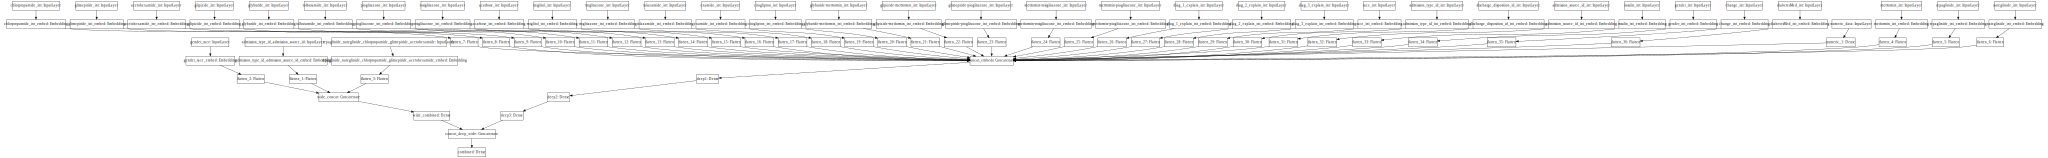

In [26]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [27]:
%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['accuracy'])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit(X_ints_train+ [X_train_num],
                    y_train,
                    epochs=30, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_num], y_test))

Train on 37284 samples, validate on 9322 samples
Epoch 1/30
37284/37284 [==============================] - 7s 187us/step - loss: 0.1688 - acc: 0.6133 - val_loss: 0.1644 - val_acc: 0.6210
Epoch 2/30
37284/37284 [==============================] - 6s 159us/step - loss: 0.1585 - acc: 0.6418 - val_loss: 0.1580 - val_acc: 0.6425
Epoch 3/30
37284/37284 [==============================] - 6s 159us/step - loss: 0.1538 - acc: 0.6572 - val_loss: 0.1547 - val_acc: 0.6574
Epoch 4/30
37284/37284 [==============================] - 6s 159us/step - loss: 0.1512 - acc: 0.6664 - val_loss: 0.1525 - val_acc: 0.6634
Epoch 5/30
37284/37284 [==============================] - 6s 161us/step - loss: 0.1496 - acc: 0.6702 - val_loss: 0.1512 - val_acc: 0.6648
Epoch 6/30
37284/37284 [==============================] - 6s 161us/step - loss: 0.1487 - acc: 0.6725 - val_loss: 0.1510 - val_acc: 0.6668
Epoch 7/30
37284/37284 [==============================] - 6s 162us/step - loss: 0.1481 - acc: 0.6743 - val_loss: 0.1502 - v

Text(0.5,0,'epochs')

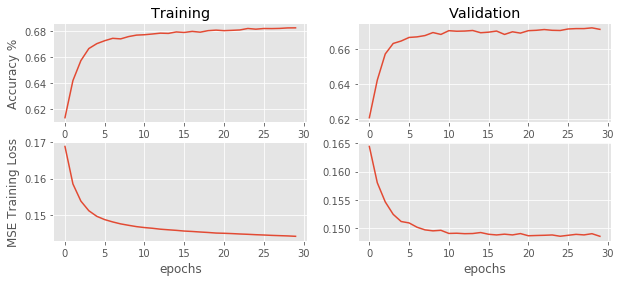

In [28]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['acc'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

In [29]:
yhat = model.predict(X_ints_test + [X_test_num])
cost = find_cost_metric(y_test,yhat,my_cost_matrix)
print(cost)

2.2593863977687194


Create the wide and deep network in the previous fashion maybe a little troublesome, thus I'll create the following wrapper.

In [27]:
'''
Let's create a wrapper, such that in the following, we can
call the wrapper to simplify the process
For creating the model
'''
def deep_and_wide(cross_columns,deep_layers):
    
    embed_branches = []
    X_ints_train = []
    X_ints_test = []
    all_inputs = []
    all_wide_branch_outputs = []

    for cols in cross_columns:
        enc = LabelEncoder()

        X_crossed_train = df_train[cols].apply(lambda x: '_'.join(x), axis=1)
        X_crossed_test = df_test[cols].apply(lambda x: '_'.join(x), axis=1)

        enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
        X_crossed_train = enc.transform(X_crossed_train)
        X_crossed_test = enc.transform(X_crossed_test)
        X_ints_train.append( X_crossed_train )
        X_ints_test.append( X_crossed_test )

        N = max(X_ints_train[-1]+1)

        inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name = '_'.join(cols)+'_embed')(inputs)
        x = Flatten()(x)
        all_wide_branch_outputs.append(x)

    wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
    wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)
    X_train_num =  df_train[numeric_headers].values
    X_test_num = df_test[numeric_headers].values

    all_deep_branch_outputs = []
    for col in categorical_headers_ints:
        X_ints_train.append( df_train[col].values )
        X_ints_test.append( df_test[col].values )

        N = max(X_ints_train[-1]+1)

        inputs = Input(shape=(1,),dtype='int32', name=col)
        all_inputs.append(inputs)
        x = Embedding(input_dim=N, 
                      output_dim=int(np.sqrt(N)), 
                      input_length=1, name=col+'_embed')(inputs)
        x = Flatten()(x)
        all_deep_branch_outputs.append(x)

    all_inputs.append(Input(shape=(X_train_num.shape[1],),
                            sparse=False,
                            name='numeric_data'))


    x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
    all_deep_branch_outputs.append( x )

    # merge the deep branches together
    deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
    
    for nbr,act,name in deep_layers:
        deep_branch = Dense(units=nbr,activation=act, name=name)(deep_branch)

    final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
    final_branch = Dense(units=3,activation='sigmoid',name='combined')(final_branch)

    model = Model(inputs=all_inputs, outputs=final_branch)
    
    return model,X_ints_train,X_train_num,X_ints_test,X_test_num

In [70]:
class deep_and_wide_all_wraped(object):
    def __init__(self,cross_columns,deep_layers,epochs):
        self.cross_columns = cross_columns
        self.deep_layers = deep_layers
        self.epochs = epochs
        
    def build_model(self):
        K.clear_session()
        self.model,self.X_ints_train,self.X_train_num,self.X_ints_test,self.X_test_num = deep_and_wide(self.cross_columns,self.deep_layers)
        self.model.compile(optimizer='adagrad',
                  loss='mean_squared_error',
                  metrics=['accuracy'])
        return self.model
    def fit(self):
        self.build_model()
        self.history = self.model.fit(self.X_ints_train+ [self.X_train_num],
                        y_train,
                        epochs=self.epochs, 
                        batch_size=32, 
                        verbose=0, 
                        validation_data = (self.X_ints_test + [self.X_test_num], y_test))
        return self.history
    
    def cost_predict(self):
        yhat = self.model.predict(self.X_ints_test + [self.X_test_num])
        cost = find_cost_metric(y_test,yhat,my_cost_matrix)
        return cost
    
    def predict(self):
        yhat = self.model.predict(self.X_ints_test + [self.X_test_num])
        return yhat
    
    def plot(self):
        plt.figure(figsize=(10,4))
        plt.subplot(2,2,1)
        plt.plot(self.history.history['acc'])

        plt.ylabel('Accuracy %')
        plt.title('Training')
        plt.subplot(2,2,2)
        plt.plot(self.history.history['val_acc'])
        plt.title('Validation')

        plt.subplot(2,2,3)
        plt.plot(self.history.history['loss'])
        plt.ylabel('MSE Training Loss')
        plt.xlabel('epochs')

        plt.subplot(2,2,4)
        plt.plot(self.history.history['val_loss'])
        plt.xlabel('epochs')

In [29]:
'''
for ploting multiple models
'''
def combined_plt(hists):
    
    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    for history in hists:
        plt.plot(history.history['acc'])

    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    for history in hists:
        plt.plot(history.history['val_acc'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    for history in hists:
        plt.plot(history.history['loss'])
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    for history in hists:
        plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')

Here is a standard procedure for creating the model and train it.

2.250268182793392


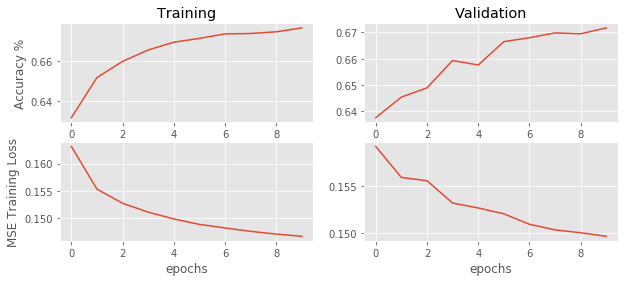

In [30]:
'''
standard form for calling the wrapper function
'''
cross_columns = [['admission_type_id','admission_source_id'],  ['gender','race']]
deep_layers = [[50,'relu','deep1'],[25,'relu','deep2'],[10,'relu','deep3']]

model = deep_and_wide_all_wraped(cross_columns,deep_layers,epochs=10)
hist = model.fit()
model.plot()
cost = model.cost_predict()
print(cost)

Recall that we've decided 6 groups of features for column crossing, in the next cell, I'll randomly select 3 groups to create a seperate model for 5 times, and compare their performance.

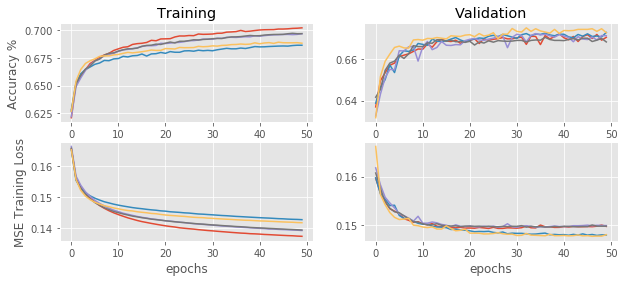

In [34]:
'''
Let's use different cross_columns to test the performance of our model
'''
hist_list = []
for i in range(5):
    random.shuffle(final_cross_columns)
    cross_columns = final_cross_columns[:3]
    deep_layers = [[50,'relu','deep1'],[25,'relu','deep2'],[10,'relu','deep3']]

    model = deep_and_wide_all_wraped(cross_columns,deep_layers,epochs=50)
    hist = model.fit()
    hist_list += [hist]

    cost = model.cost_predict()
#    print(cost)

combined_plt(hist_list)

From the validation plot above, we can tell that certain types of crossed columns are definitely providing better results than the rest. But I believe that if we include all the possible crossed columns, the model will be more robust. Including more crossed columns which are reasonable will make the model more flexable, the extended model includes the original model theoretically, and since our dataset is quite large ~ 100,000, it's not likely to be overfitted, thus more crossed columns will be better.(including more crossed columns will just add ~100 more parameters for training.)

<a id="generalization"></a>
### Generalization Performace
 > __[20 points]__ investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly. 

Here, I'll create 32 models with different numbers of layers and different activation functions, and find the optimal combination of parameters.

Also, all the cross_columns will be applied.

In [59]:
import random
param_test = []
cost_list = []
activation_list = ['tanh','softsign','relu','sigmoid','hard_sigmoid','linear']
for i in range(8):
    for k in range(4):
        act = activation_list[random.randint(0, 5)]
        deep_layers = [[50,act,'deep1']]
        for j in range(i):
            act = activation_list[random.randint(0, 5)]
            deep_layers += [[25,act,'deep'+str(2+j)]]
        act = activation_list[random.randint(0, 5)]
        deep_layers += [[5,act,'deep'+str(2+i)]]
        
        model = deep_and_wide_all_wraped(final_cross_columns,deep_layers,epochs=10)
        hist = model.fit()

        cost = model.cost_predict()


        param_test += [deep_layers]
        cost_list += [cost]

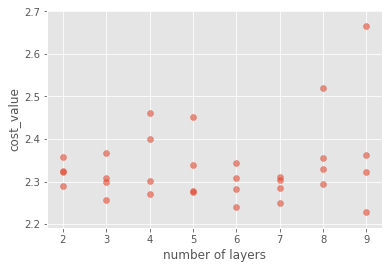

In [60]:
x_axis = [len(param_set) for param_set in param_test]
y_axis = cost_list
plt.scatter(x_axis, y_axis, alpha=0.6)
plt.xlabel('number of layers')
plt.ylabel('cost_value')
plt.show()

Since the 9 layers have large variance, we select the second best parameter set.

In [62]:
best_param = sorted([t for t in zip(param_test,cost_list)], key = lambda t: t[1])[1][0]
print('Best set of parameters are: ',best_param)

Best set of parameters are:  [[50, 'relu', 'deep1'], [25, 'hard_sigmoid', 'deep2'], [25, 'linear', 'deep3'], [25, 'sigmoid', 'deep4'], [25, 'softsign', 'deep5'], [5, 'linear', 'deep6']]


From the previous cell, we find that the deep network that gives best result contains 6 hidden layers. And it's interesting to see that the activations of some layers are linear (recall that in the last lab, the activation of the first layer of the best set of parameters is also linear), since if the activation function is linear, then this hidden layer can be removed. One possible explaination for this is that it's quite difficult for the gradient descend method to find the global minimal point. Thus, although 6 layers with linear activation function is kind of redudant, it still has the best performance.

<a id="compare"></a>
### Compare to Multi - Layter Perceptron

> __[10 points]__ Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). For classification tasks, use the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical method to compare the performance of different models. 

2.2715082600300365


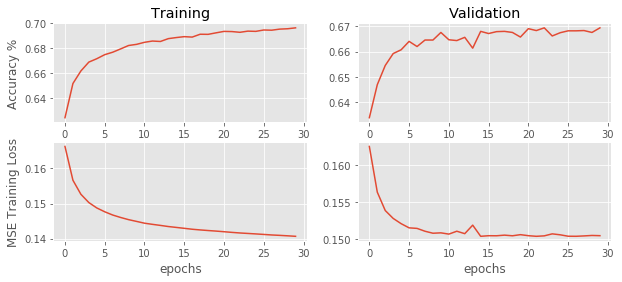

In [96]:
'''First, lets train our best wide and deep model'''
cross_columns = final_cross_columns
deep_layers = best_param

model = deep_and_wide_all_wraped(cross_columns,deep_layers,epochs=30)
hist = model.fit()
model.plot()
cost = model.cost_predict()
print(cost)

We can see that when epochs is large, the validation gets worse, which is resulted from overtraining. We will use the result from 10 epochs.

In [98]:
yhat_wide_and_deep = model.predict()
y_true = [convert_back(y_val) for y_val in y_test]
y_pred_wide_and_deep = [convert_back(y_val) for y_val in yhat_wide_and_deep]

<Figure size 432x288 with 0 Axes>

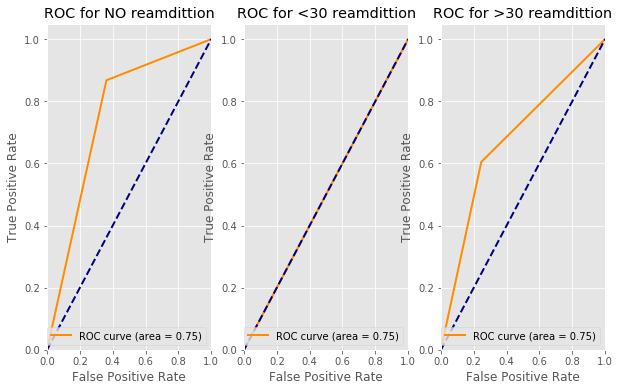

AUC for NO readmittion:  0.7530362847559583
AUC for <30 readmittion:  0.5
AUC for >30 readmittion:  0.679508351044875
AUC average:  0.6441815452669444


In [113]:
from sklearn.metrics import roc_curve, auc
y_true_1 = [1 if val==0 else 0 for val in y_true]
y_pred_wide_and_deep_1 = [1 if val==0 else 0 for val in y_pred_wide_and_deep]

y_true_2 = [1 if val==1 else 0 for val in y_true]
y_pred_wide_and_deep_2 = [1 if val==1 else 0 for val in y_pred_wide_and_deep]

y_true_3 = [1 if val==2 else 0 for val in y_true]
y_pred_wide_and_deep_3 = [1 if val==2 else 0 for val in y_pred_wide_and_deep]

fpr_1,tpr_1,threshold_2 = roc_curve(y_true_1, y_pred_wide_and_deep_1)
fpr_2,tpr_2,threshold_2 = roc_curve(y_true_2, y_pred_wide_and_deep_2)
fpr_3,tpr_3,threshold_3 = roc_curve(y_true_3, y_pred_wide_and_deep_3)

roc_auc_1 = auc(fpr_1,tpr_1)
roc_auc_2 = auc(fpr_2,tpr_2)
roc_auc_3 = auc(fpr_3,tpr_3)

plt.figure()
lw = 2

plt.figure(figsize=(10,6))

plt.subplot(1,3,1)
plt.plot(fpr_1, tpr_1, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for NO reamdittion')
plt.legend(loc="lower right")

plt.subplot(1,3,2)
plt.plot(fpr_2, tpr_2, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for <30 reamdittion')
plt.legend(loc="lower right")

plt.subplot(1,3,3)
plt.plot(fpr_3, tpr_3, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for >30 reamdittion')
plt.legend(loc="lower right")
plt.show()

print('AUC for NO readmittion: ',roc_auc_1)
print('AUC for <30 readmittion: ',roc_auc_2)
print('AUC for >30 readmittion: ',roc_auc_3)

print('AUC average: ',(roc_auc_1+roc_auc_2+roc_auc_3)/3)
roc_ave_wide_and_deep = (roc_auc_1+roc_auc_2+roc_auc_3)/3

In [110]:
'''
Data preparation for standard MLP, we need to one hot encode the catagorical data.
Also the OneHotEncoder will return sparse matrix, need to transform to dense matrix before stack them with numeric data
'''
from sklearn.preprocessing import OneHotEncoder

# now let's encode the integer outputs as one hot encoded labels
ohe = OneHotEncoder()
#important: add .toarray()
X_train_ohe = ohe.fit_transform(df_train[categorical_headers_ints].values).toarray()
X_test_ohe = ohe.transform(df_test[categorical_headers_ints].values).toarray()


# and save off the numeric features
X_train_num =  df_train[numeric_headers].values
X_test_num = df_test[numeric_headers].values
X_train = np.column_stack((X_train_ohe,X_train_num))
X_test = np.column_stack((X_test_ohe,X_test_num))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 179)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                9000      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_4 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_5 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 130       
__________

Text(0.5,0,'epochs')

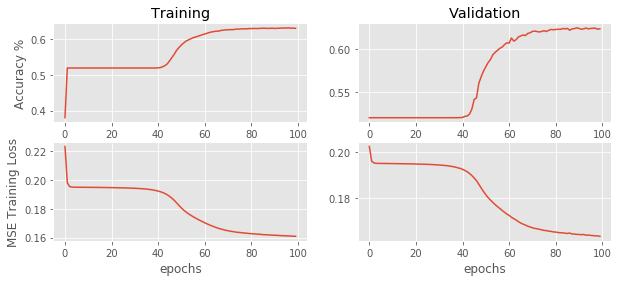

In [111]:
'''
Standard MLP
'''
# This returns a tensor
inputs = Input(shape=(X_train.shape[1],))

# Using some configuration for the deep part
x = Dense(units=50, activation='relu')(inputs)
x = Dense(units=25, activation='hard_sigmoid')(x)
x = Dense(units=25, activation='linear')(x)
x = Dense(units=25, activation='sigmoid')(x)
x = Dense(units=25, activation='softsign')(x)
x = Dense(units=5, activation='linear')(x)

predictions = Dense(3,activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.summary()

history = model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=0,validation_data = (X_test, y_test))
yhat_MLP = model.predict(X_test)
cost = find_cost_metric(y_test,yhat_MLP,my_cost_matrix)
print(cost)
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['acc'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

In [112]:
y_true = [convert_back(y_val) for y_val in y_test]
y_pred_MLP = [convert_back(y_val) for y_val in yhat_MLP]

<Figure size 432x288 with 0 Axes>

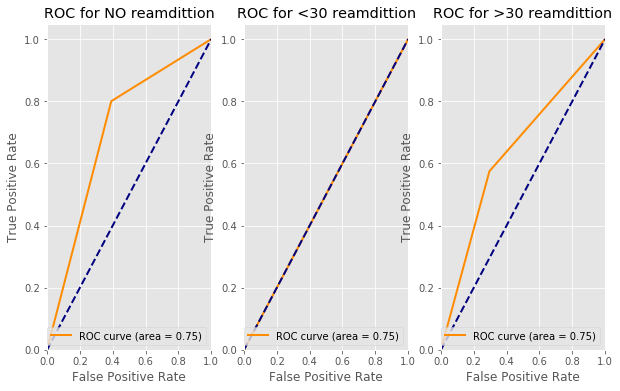

AUC for NO readmittion:  0.7046513391573904
AUC for <30 readmittion:  0.5
AUC for >30 readmittion:  0.6397407344510618
AUC average:  0.6147973578694841


In [114]:
y_true_1 = [1 if val==0 else 0 for val in y_true]
y_pred_MLP_1 = [1 if val==0 else 0 for val in y_pred_MLP]

y_true_2 = [1 if val==1 else 0 for val in y_true]
y_pred_MLP_2 = [1 if val==1 else 0 for val in y_pred_MLP]

y_true_3 = [1 if val==2 else 0 for val in y_true]
y_pred_MLP_3 = [1 if val==2 else 0 for val in y_pred_MLP]

fpr_1,tpr_1,threshold_2 = roc_curve(y_true_1, y_pred_MLP_1)
fpr_2,tpr_2,threshold_2 = roc_curve(y_true_2, y_pred_MLP_2)
fpr_3,tpr_3,threshold_3 = roc_curve(y_true_3, y_pred_MLP_3)

roc_auc_1 = auc(fpr_1,tpr_1)
roc_auc_2 = auc(fpr_2,tpr_2)
roc_auc_3 = auc(fpr_3,tpr_3)

plt.figure()
lw = 2

plt.figure(figsize=(10,6))

plt.subplot(1,3,1)
plt.plot(fpr_1, tpr_1, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for NO reamdittion')
plt.legend(loc="lower right")

plt.subplot(1,3,2)
plt.plot(fpr_2, tpr_2, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for <30 reamdittion')
plt.legend(loc="lower right")

plt.subplot(1,3,3)
plt.plot(fpr_3, tpr_3, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for >30 reamdittion')
plt.legend(loc="lower right")
plt.show()

print('AUC for NO readmittion: ',roc_auc_1)
print('AUC for <30 readmittion: ',roc_auc_2)
print('AUC for >30 readmittion: ',roc_auc_3)

print('AUC average: ',(roc_auc_1+roc_auc_2+roc_auc_3)/3)
roc_ave_MLP = (roc_auc_1+roc_auc_2+roc_auc_3)/3

So the ROC can be applied when it's two class classification usually, here we need to convert our problem to three two class classification first. This is why we have three ROC curves for each model.

The shape of ROC for wide and deep versus standard MLP are similar, but the AUC of the wide and deep is larger than the standard MLP, which means it has better performace. (However this is not for sure, we will compare the two models statistically below.)

To compare wide and deep models versus standard MLP, we can consider the performance of all 6 hidden layers deep and wide models as Gaussian distribution, then check if the standard MLP is with 95% deviation. We can use scipy library for this purpose.

In [65]:
cost_6_hidden_layer = []
for t in zip(param_test,cost_list):
    if len(t[0]) == 6:
        cost_6_hidden_layer += [t[1]]
print(cost_6_hidden_layer)

[2.309268397339627, 2.281377386826861, 2.3427376099549453, 2.2408281484659947]


In [119]:
import numpy as np, scipy.stats as st
st_range = st.t.interval(0.95, len(cost_6_hidden_layer)-1, loc=np.mean(cost_6_hidden_layer), scale=st.sem(cost_6_hidden_layer))
print(st_range)
print('MLP cost (customized metric) is', cost)

(2.2248394608721243, 2.36226631042159)
MLP cost (customized metric) is 2.64707144389616


In [118]:
print('MLP is indisguishable compared to wide and deep network: ' ,cost>=st_range[0] and cost<= st_range[1])

MLP is indisguishable compared to wide and deep network:  False


Actually we can see that the cost (customized metric) of MLP is larger than all costs of wide and deep networks, thus we can say that wide and deep networks have better performance.

<a id="exceptional"></a>
## Exceptional Work

<a id="embedded_weights"></a>
### Embedded Weights

> One idea (__required for 7000 level students__): Capture the embedding weights from the deep network and (if needed) perform t-SNE clustering on the output of these embedding layers. That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data.

In [71]:
'''
Train the model with best performance
'''
cross_columns = final_cross_columns
deep_layers = best_param

model, X_ints_train,X_train_num,X_ints_test,X_test_num = deep_and_wide(cross_columns,deep_layers)

model.compile(optimizer='adagrad',loss='mean_squared_error',metrics=['accuracy'])

history = model.fit(X_ints_train+ [X_train_num],
                    y_train,
                    epochs=10, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_num], y_test))

sample_size = 5000

Train on 37284 samples, validate on 9322 samples
Epoch 1/10
37284/37284 [==============================] - 8s 215us/step - loss: 0.1684 - acc: 0.6164 - val_loss: 0.1641 - val_acc: 0.6277
Epoch 2/10
37284/37284 [==============================] - 7s 181us/step - loss: 0.1610 - acc: 0.6354 - val_loss: 0.1621 - val_acc: 0.6296
Epoch 3/10
37284/37284 [==============================] - 7s 181us/step - loss: 0.1592 - acc: 0.6379 - val_loss: 0.1618 - val_acc: 0.6287
Epoch 4/10
37284/37284 [==============================] - 7s 180us/step - loss: 0.1578 - acc: 0.6409 - val_loss: 0.1604 - val_acc: 0.6323
Epoch 5/10
37284/37284 [==============================] - 7s 180us/step - loss: 0.1566 - acc: 0.6443 - val_loss: 0.1594 - val_acc: 0.6339
Epoch 6/10
37284/37284 [==============================] - 7s 180us/step - loss: 0.1554 - acc: 0.6483 - val_loss: 0.1593 - val_acc: 0.6367
Epoch 7/10
37284/37284 [==============================] - 7s 180us/step - loss: 0.1542 - acc: 0.6524 - val_loss: 0.1582 - v

In [72]:
dense1_layer_model = Model(inputs=model.input, outputs=model.get_layer('deep1').output)

dense1_output_1 = dense1_layer_model.predict(X_ints_train+ [X_train_num])
dense1_output_2 = dense1_layer_model.predict(X_ints_test + [X_test_num])

In [73]:
'''t-SNE'''
from sklearn import manifold

tsne_1 = manifold.TSNE(n_components=2, init='pca', random_state=501,verbose=0)
tsne_2 = manifold.TSNE(n_components=2, init='pca', random_state=501,verbose=0)

print('t-SNE model built!')

X_tsne_1 = tsne_1.fit_transform(dense1_output_1[:sample_size])
X_tsne_2 = tsne_2.fit_transform(dense1_output_2[:sample_size])

print("Orginal data dimension is {}. Embedded data dimension is {}".format(dense1_output_1.shape[-1], X_tsne_1.shape[-1]))

t-SNE model built!
Orginal data dimension is 50. Embedded data dimension is 2


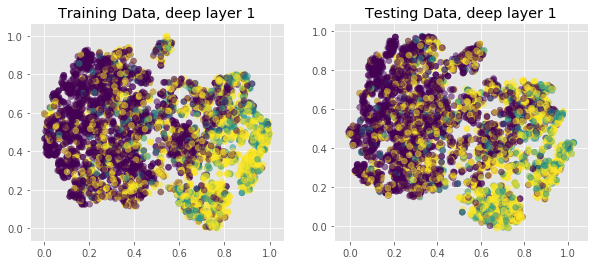

In [74]:
x_min, x_max = X_tsne_1.min(0), X_tsne_1.max(0)
X_norm_1 = (X_tsne_1 - x_min) / (x_max - x_min)
X_norm_2 = (X_tsne_2 - x_min) / (x_max - x_min)

y_train = df_train['readmitted'].replace({'NO':0,'<30':1,'>30':2}).values
y_test = df_test['readmitted'].replace({'NO':0,'<30':1,'>30':2}).values

colors_1 = (y_train/3+0.1)[:sample_size]
colors_2 = (y_test/3+0.1)[:sample_size]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title('Training Data, deep layer 1')
plt.scatter(np.transpose(X_norm_1)[0], np.transpose(X_norm_1)[1],c=colors_1, alpha=0.5)

plt.subplot(1,2,2)
plt.title('Testing Data, deep layer 1')
plt.scatter(np.transpose(X_norm_2)[0], np.transpose(X_norm_2)[1],c=colors_2, alpha=0.5)

In the plot above, we have three colors: purple, yellow and green, which represents 'No', '<30', and '>30' in the readmitted column seperately.

As we can see in the plot above, the training and testing data have similar spatial distribution, which shows that our training-testing split is valid. And from the color seperation, we can see that the neural network is working, but not so effective. We can try the result of a latter layer.

t-SNE model built!
Orginal data dimension is 25. Embedded data dimension is 2


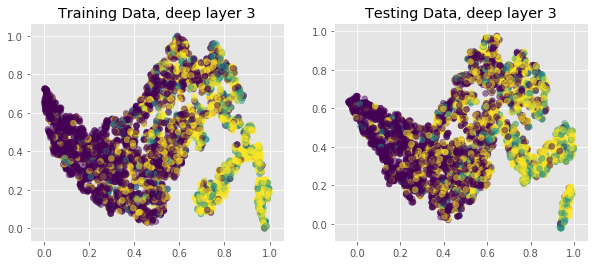

In [75]:
dense3_layer_model = Model(inputs=model.input, outputs=model.get_layer('deep3').output)

dense3_output_1 = dense3_layer_model.predict(X_ints_train+ [X_train_num])
dense3_output_2 = dense3_layer_model.predict(X_ints_test + [X_test_num])

tsne_1 = manifold.TSNE(n_components=2, init='pca', random_state=501,verbose=0)
tsne_2 = manifold.TSNE(n_components=2, init='pca', random_state=501,verbose=0)

print('t-SNE model built!')

X_tsne_1 = tsne_1.fit_transform(dense3_output_1[:sample_size])
X_tsne_2 = tsne_2.fit_transform(dense3_output_2[:sample_size])

print("Orginal data dimension is {}. Embedded data dimension is {}".format(dense3_output_1.shape[-1], X_tsne_1.shape[-1]))
x_min, x_max = X_tsne_1.min(0), X_tsne_1.max(0)
X_norm_1 = (X_tsne_1 - x_min) / (x_max - x_min)
X_norm_2 = (X_tsne_2 - x_min) / (x_max - x_min)

y_train = df_train['readmitted'].replace({'NO':0,'<30':1,'>30':2}).values
y_test = df_test['readmitted'].replace({'NO':0,'<30':1,'>30':2}).values

colors_1 = (y_train/3+0.1)[:sample_size]
colors_2 = (y_test/3+0.1)[:sample_size]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.title('Training Data, deep layer 3')
plt.scatter(np.transpose(X_norm_1)[0], np.transpose(X_norm_1)[1],c=colors_1, alpha=0.5)

plt.subplot(1,2,2)
plt.title('Testing Data, deep layer 3')
plt.scatter(np.transpose(X_norm_2)[0], np.transpose(X_norm_2)[1],c=colors_2, alpha=0.5)

We can see that even in latter layer, the colors are not totally seperated, which is reasonable since that the general accuracy of our model is around 70%.

<a id="additional_analysis"></a>
### Additional Analysis

> You have free reign to provide additional analyses.


<a id="Two-Phase Training"></a>
#### Two-Phase Training

Most of the time, the neural network will not reach a global minimal within finite epochs, which means that the wide and deep network might not have a better performance comparing to the standard MLP. However, since the standard MLP can be part of the deep network, we can train the standard MLP, then let the wide and deep network adopt the weight, and set all the rest of the parameters to zero as the initial state. Then, when we start training from here, we are garenteed to have a wide and deep network with better performance.

<a id="important_features"></a>
#### Important Features

Along with the machine learning, it is often beneficial to try and find what features in the full dataset are most likely to contribute to the patient returning to the hospital. This may be useful to convey information to people who may not have a background in math, _e.g._ explaining what a principal component is to someone who hasn't had any math since high school. One way to provide this information is to use PCA to find the principal components, then apply the inverse of the PCA transform to an identity matrix. The first step will allow us to see what principal components contribute to the total variance the most. Applying the inverse transform to the identity matrix will then allow us to see how much each of the original features contributed to the principal components. Along the way we can also make some visualizations because staring at tables of weights is a quick way to put people to sleep.

In [25]:
# first, read in the previous processed data
import pickle

imp_df = pd.read_pickle('data/processed_data.pickle')
imp_df.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,...,admission_source_id_category_13,admission_source_id_category_14,admission_source_id_category_17,admission_source_id_category_20,admission_source_id_category_22,admission_source_id_category_25,insulin_category_No,insulin_category_Steady,insulin_category_Up,freq
1,1.0,-3.273606,-0.472151,0.816634,-0.788883,0.237993,-0.293725,-0.213723,-0.506292,0.819431,...,0,0,0,0,0,0,0,0,1,-0.521254
2,1.0,-2.632219,-0.808164,-1.626586,2.142511,-0.381226,1.267109,-0.213723,0.281984,-0.811724,...,0,0,0,0,0,0,1,0,0,-0.521254
3,0.0,-1.990832,-0.808164,0.053127,-0.202604,-0.009694,-0.293725,-0.213723,-0.506292,-0.268006,...,0,0,0,0,0,0,0,0,1,-0.521254
4,0.0,-1.349445,-1.144178,0.409430,-0.788883,-1.000445,-0.293725,-0.213723,-0.506292,-1.355443,...,0,0,0,0,0,0,0,1,0,-0.521254
5,0.0,-0.708058,-0.472151,-0.608578,2.728790,-0.009694,-0.293725,-0.213723,-0.506292,0.819431,...,0,0,0,0,0,0,0,1,0,-0.521254


PCA model built!
Orginal data dimension is 155. Embedded data dimension is 155


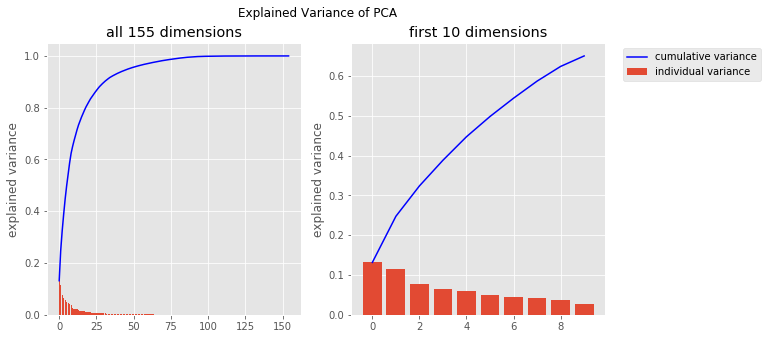

In [26]:
# look at PCA
from sklearn.decomposition import PCA
import seaborn as sns

# first split the data from the target
data_cols = list(imp_df)
data_cols.remove('readmitted')
data = imp_df[data_cols]
target = imp_df['readmitted']

# now do PCA on the data
pca = PCA(n_components=len(data_cols), random_state=1)
print('PCA model built!')

data_pca_fit = pca.fit_transform(data.copy())
#X_PCA = X_PCA_fit.transform(X)
explained_var = pca.explained_variance_ratio_
print("Orginal data dimension is {}. Embedded data dimension is {}".format(data.shape[-1], data_pca_fit.shape[-1]))
#print("cumulative explained variance : {}".format(np.cumsum(explained_var)))

fig = plt.figure(figsize = (10,5))
fig.suptitle('Explained Variance of PCA')
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.set(title='all {} dimensions'.format(len(data_cols)), ylabel='explained variance')
ax1.bar(np.arange(0,len(explained_var),1),explained_var)
ax1.plot(np.arange(0,len(explained_var),1), np.cumsum(explained_var), 'b-')
ax2.set(title='first 10 dimensions', ylabel='explained variance')
ax2.bar(np.arange(0,10,1),explained_var[:10])
ax2.plot(np.arange(0,10,1), np.cumsum(explained_var[:10]), 'b-')
ax2.legend(['cumulative variance', 'individual variance'], bbox_to_anchor=(1.05, 1))
plt.show()

[[  5.46835475e-01   8.01849699e-02   4.62458885e-01   3.32863659e-01]
 [  5.48813747e-01  -1.55821800e-01  -2.26212623e-01  -1.58004972e-01]
 [  5.11542977e-01  -7.02265590e-01   3.16730582e-02  -7.21587041e-03]
 [  5.22551339e-01   1.35803808e-01  -1.94046099e-01  -6.06131759e-01]
 [  5.43000320e-01  -3.17388066e-01   6.79316193e-04   3.39576014e-01]
 [  5.37042729e-01  -9.80991965e-03  -1.11478531e-01  -5.36134504e-03]
 [  5.78429098e-01   4.94847094e-01   2.48813714e-01   1.09044453e-01]
 [  4.91429895e-01   7.46644566e-02  -3.83794424e-01   5.02304668e-01]
 [  5.57225539e-01  -1.71599047e-01   6.04924137e-01  -2.19103383e-01]
 [  5.83658362e-01  -9.94436435e-02  -2.08542788e-01  -9.41936990e-03]]


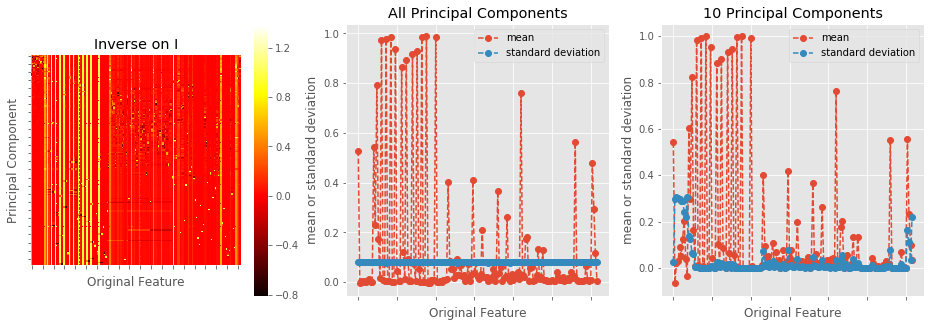

In [27]:
# now look at the features most contributing to the PCA

# this doesn't appear to be working as expected

#p_comp = [0]*data.shape[1]
#p_comp[0] = 1

inv_dat = pca.inverse_transform(np.eye(data.shape[1]))
#inv_dat = pca.inverse_transform(np.diag(p_comp))
mean = inv_dat.mean(axis=0)
std = inv_dat.std(axis=0)
print(inv_dat[:10,:4])

mean_10 = inv_dat[:][:10].mean(axis=0)
std_10 = inv_dat[:][:10].std(axis=0)

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (16,5))

axes[0] = sns.heatmap(inv_dat, cmap="hot", cbar=True, ax=axes[0])
axes[0].set(xlabel='Original Feature', ylabel='Principal Component', yticklabels=[], xticklabels=[], title='Inverse on I',
           aspect='equal')

axes[1].plot(mean, '--o', label='mean')
axes[1].plot(std, '--o', label='standard deviation')
axes[1].set(xlabel='Original Feature', ylabel='mean or standard deviation', xticklabels=[], title='All Principal Components')
axes[1].legend()

axes[2].plot(mean_10, '--o', label='mean')
axes[2].plot(std_10, '--o', label='standard deviation')
axes[2].set(xlabel='Original Feature', ylabel='mean or standard deviation', xticklabels=[], title='10 Principal Components')
axes[2].legend()

plt.show()

In the above left plot we can see a heat map of the result from applying the inverse PCA transform on an identity matrix. In this plot we can see that some of the original features contributed much more than others. 

On the center plot we have averaged the contributions from the orignal features over the principal components. This give us information about how much the original feature contributed to all of the components. 

On the right plot we have averaged over the first 10 principal components. This tells us what original features contribued to the 10 principal components that contributed the most to the total variance in the original dataset.

for a threshold of 0.1 we keep 31 features


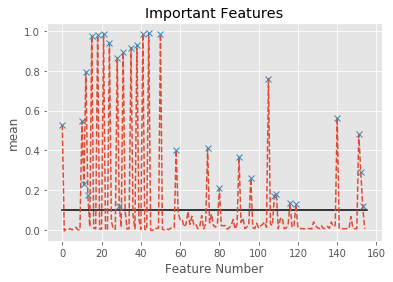

In [28]:
# not get the "most important" feautures from the original data
threshold = 0.1
ids = np.argwhere(mean > threshold)[:,0]
important_cols = [data_cols[i] for i in ids]
important_means = [mean[i] for i in ids]
print('for a threshold of {} we keep {} features'.format(threshold, len(important_cols)))
      
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('Important Features')
ax.set_ylabel('mean')
ax.set_xlabel('Feature Number')
ax.plot([0,len(mean)], [threshold,threshold], 'k-', label = 'threshold')
ax.plot(mean, '--', label = 'mean')
ax.plot(ids, important_means, 'x')
plt.show()

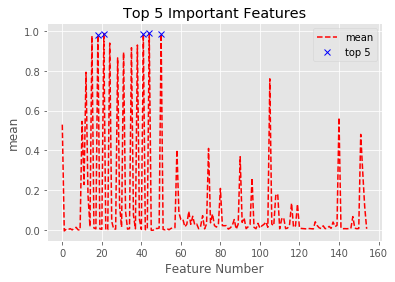

The top 5 most important features (in descending order) are 
1 = miglitol_category_No
2 = chlorpropamide_category_No
3 = acarbose_category_No
4 = glyburide-metformin_category_No
5 = nateglinide_category_No


In [29]:
# top 5
n_keep = 5
top_n_indices = sorted(range(len(mean)), key=lambda i: mean[i], reverse=True)[:n_keep]
top_n_means = [mean[i] for i in top_n_indices]
top_n_features = [data_cols[i] for i in top_n_indices]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title('Top {} Important Features'.format(n_keep))
ax.set_ylabel('mean')
ax.set_xlabel('Feature Number')
ax.plot(mean, 'r--', label = 'mean')
ax.plot(top_n_indices, top_n_means, 'bx', label='top {}'.format(n_keep))
ax.legend()
plt.show()

print('The top {} most important features (in descending order) are '.format(n_keep))
for j in range(n_keep):
    print('{} = {}'.format(j+1, top_n_features[j]))

Above we can see that we can find the "most important" features, or the features that contribute to the principal components the most. In this instance, we make a cut on the mean. We also find the 5 features that contribute the most. On a side note, these features are not at all what I would have expected.

<a id="thoughts"></a>
## Final Thoughts

- We may be able to reduce the number of features be combining all of the medication columns into two features, the number of changes in medications and a second column containg the total number of medications taken by the patient. 

- We could also potentially reduce the dimensionality of our problem by combining the admission ids into groups. For instance admission source ids 1 (Emergency), 2 (Urgend), and 7 (Trauma Center) are all non-elective. Reducing the number of categories here would reduce the number of features afer one hot encoding.

- We may be able to make use of the HbA1c results by combining this column with the max glucose serum column. We could combine these into high, normal, low, and (potentially) not measured. Although the two individual columns were dropped because they didn't contain enough data, the combined result may have enough data to be used.

- We kept each individual result from patients who were included in the dataset multiple times (we kept rows with the same patient id). If we were to collapse these into a single column we would have to think about how to combine multiple stays. For example, the stay length could be the average of the stay lenghts for each individual encounter. Doing this would slightly change the question we want to answer with this project. By combining we could answer "how likely is a patient to be readmitted". This __more__